In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates


import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.helpers import store_model
from shared.metrics import print_evaluation_metrics
from shared.spektral_utilities import *
from shared.spektral_gcn import GraphConv

2024-04-14 12:03:52.804834: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 12:03:52.844985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 12:03:52.845020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 12:03:52.845996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 12:03:52.852610: I tensorflow/core/platform/cpu_feature_guar

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
id_column = "WHO_region"
df = pd.read_csv(file_path)[[date_column, target_column, id_column]]
df[date_column] = pd.to_datetime(df[date_column])
df = df.groupby([date_column, id_column])[target_column].sum().reset_index()
unique_dates = df[date_column].unique()
um_countries_regions = len(df[id_column].unique())
df.head()

,Date_reported,WHO_region,New_deaths
0,2020-02-02,AFRO,49.0
1,2020-02-02,AMRO,56.0
2,2020-02-02,EMRO,22.0
3,2020-02-02,EURO,65.0
4,2020-02-02,Other,1.0


In [3]:
pivot_df = df.pivot_table(index=date_column, columns=id_column, values=target_column)

df.rename(columns={"index": date_column}, inplace=True)
df.head()


,Date_reported,WHO_region,New_deaths
0,2020-02-02,AFRO,49.0
1,2020-02-02,AMRO,56.0
2,2020-02-02,EMRO,22.0
3,2020-02-02,EURO,65.0
4,2020-02-02,Other,1.0


In [4]:
unstaked_df = df.copy()
unstaked_df["id"] = unstaked_df["WHO_region"]
unstaked_df.set_index(["id", "Date_reported"], inplace=True)

# Dropping columns not needed for the analysis
unstaked_df.drop(["WHO_region"], axis=1, inplace=True)

# Converting data to float and unstacking
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

# Displaying the shape and head of the updated DataFrame
print(unstaked_df.shape)
unstaked_df.iloc[:, :15].head()

(7, 1390)


Date_reported,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16
id,,,,,,,,,,,,,,,
AFRO,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
AMRO,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0
EMRO,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
EURO,65.0,62.0,63.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,63.0
Other,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14



def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_store = all_sequence.reshape((-1, um_countries_regions, seq_len))
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(sequence_length/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(sequence_length/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, um_countries_regions))

In [6]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = unique_dates[0]
valid_date = unique_dates[int(len(unique_dates) *0.8)+1]
test_date = unique_dates[int(len(unique_dates) *0.9)]

In [7]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date + timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_train_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_train_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_train_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_train = np.concatenate(y, axis=0).astype("float16")

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

  0%|          | 0/1100 [00:00<?, ?it/s]/home/samuell/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/samuell/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_156387/14441469.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(group_store, axis=2),
/tmp/ipykernel_156387/14441469.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(group_store, axis=2),
  3%|▎         | 34/1100 [00:00<00:03, 338.94it/s]

100%|██████████| 1100/1100 [00:03<00:00, 334.13it/s]

(1100, 14, 7) (1100, 7, 7) (1100, 7, 7) (1100, 7)


In [8]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date + timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_valid_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_valid_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_valid_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_valid = np.concatenate(y, axis=0).astype("float16")

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_156387/14441469.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(group_store, axis=2),
/tmp/ipykernel_156387/14441469.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(group_store, axis=2),
100%|██████████| 125/125 [00:00<00:00, 319.04it/s]

(125, 14, 7) (125, 7, 7) (125, 7, 7) (125, 7)


In [9]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(
    pd.date_range(test_date + timedelta(days=sequence_length), unique_dates[-1])
):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_test_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_test_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_test_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_test = np.concatenate(y, axis=0).astype("float16")

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_156387/14441469.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(group_store, axis=2),
/tmp/ipykernel_156387/14441469.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(group_store, axis=2),
100%|██████████| 125/125 [00:00<00:00, 316.11it/s]

(125, 14, 7) (125, 7, 7) (125, 7, 7) (125, 7)


In [10]:
X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

In [11]:
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model():
    set_seed(33)

    opt = Adam(lr=15)

    inp_seq = Input((sequence_length, um_countries_regions))
    inp_lap = Input((um_countries_regions, um_countries_regions))
    inp_feat = Input((um_countries_regions, X_train_feat.shape[-1]))

    x = GraphConv(256, activation="relu")([inp_feat, inp_lap])
    x = GraphConv(128, activation="relu")([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(256, activation="relu", return_sequences=True)(inp_seq)
    xx = LSTM(128, activation="relu")(xx)

    x = Concatenate()([x, xx])
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.1)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(
        optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

In [12]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 7, 7)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 7, 7)]               0         []                            
                                                                                                  
 graph_conv (GraphConv)      (None, 7, 256)               2048      ['input_3[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 14, 7)]              0         []                        

In [13]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)

for region in range(um_countries_regions):
    print("-------", "region", region, "-------")

    es = EarlyStopping(
        patience=5,
        verbose=1,
        min_delta=5,
        monitor="val_loss",
        mode="auto",
        restore_best_weights=True,
    )

    model = get_model()
    model.fit(
        [X_train_seq, X_train_lap, X_train_feat],
        y_train[:, region],
        epochs=1000,
        batch_size=30,
        validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:, region]),
        callbacks=[es],
        verbose=2,
    )

    pred_valid_all[:, region] = model.predict(
        [X_valid_seq, X_valid_lap, X_valid_feat]
    ).ravel()
    pred_test_all[:, region] = model.predict(
        [X_test_seq, X_test_lap, X_test_feat]
    ).ravel()
    store_model(model, f"gnn_{region}")



pred_valid_all = pred_valid_all
reverse_valid = y_valid
pred_test_all = pred_test_all
reverse_test = y_test

------- region 0 -------
Epoch 1/1000
37/37 - 3s - loss: 79037.5391 - root_mean_squared_error: 281.1362 - val_loss: 2410.2202 - val_root_mean_squared_error: 49.0940 - 3s/epoch - 91ms/step
Epoch 2/1000
37/37 - 1s - loss: 78963.0469 - root_mean_squared_error: 281.0036 - val_loss: 2392.6704 - val_root_mean_squared_error: 48.9149 - 833ms/epoch - 23ms/step
Epoch 3/1000
37/37 - 1s - loss: 78885.4844 - root_mean_squared_error: 280.8656 - val_loss: 2372.0305 - val_root_mean_squared_error: 48.7035 - 836ms/epoch - 23ms/step
Epoch 4/1000
37/37 - 1s - loss: 78786.4531 - root_mean_squared_error: 280.6893 - val_loss: 2345.9004 - val_root_mean_squared_error: 48.4345 - 857ms/epoch - 23ms/step
Epoch 5/1000
37/37 - 1s - loss: 78660.1328 - root_mean_squared_error: 280.4641 - val_loss: 2311.2268 - val_root_mean_squared_error: 48.0752 - 878ms/epoch - 24ms/step
Epoch 6/1000
37/37 - 1s - loss: 78494.6875 - root_mean_squared_error: 280.1690 - val_loss: 2266.5322 - val_root_mean_squared_error: 47.6081 - 868ms/

------- region 1 -------
Epoch 1/1000
37/37 - 3s - loss: 11272714.0000 - root_mean_squared_error: 3357.4863 - val_loss: 116013.4922 - val_root_mean_squared_error: 340.6075 - 3s/epoch - 83ms/step
Epoch 2/1000
37/37 - 1s - loss: 11271627.0000 - root_mean_squared_error: 3357.3245 - val_loss: 115959.0312 - val_root_mean_squared_error: 340.5276 - 807ms/epoch - 22ms/step
Epoch 3/1000
37/37 - 1s - loss: 11270667.0000 - root_mean_squared_error: 3357.1814 - val_loss: 115899.7969 - val_root_mean_squared_error: 340.4406 - 838ms/epoch - 23ms/step
Epoch 4/1000
37/37 - 1s - loss: 11269557.0000 - root_mean_squared_error: 3357.0161 - val_loss: 115830.1562 - val_root_mean_squared_error: 340.3383 - 855ms/epoch - 23ms/step
Epoch 5/1000
37/37 - 1s - loss: 11268232.0000 - root_mean_squared_error: 3356.8188 - val_loss: 115744.7266 - val_root_mean_squared_error: 340.2128 - 847ms/epoch - 23ms/step
Epoch 6/1000
37/37 - 1s - loss: 11266606.0000 - root_mean_squared_error: 3356.5764 - val_loss: 115638.0234 - val_

------- region 2 -------
Epoch 1/1000
37/37 - 3s - loss: 195609.4688 - root_mean_squared_error: 442.2776 - val_loss: 736.6880 - val_root_mean_squared_error: 27.1420 - 3s/epoch - 84ms/step
Epoch 2/1000
37/37 - 1s - loss: 195485.7188 - root_mean_squared_error: 442.1377 - val_loss: 727.7641 - val_root_mean_squared_error: 26.9771 - 839ms/epoch - 23ms/step
Epoch 3/1000
37/37 - 1s - loss: 195356.4688 - root_mean_squared_error: 441.9915 - val_loss: 717.2266 - val_root_mean_squared_error: 26.7811 - 866ms/epoch - 23ms/step
Epoch 4/1000
37/37 - 1s - loss: 195193.7656 - root_mean_squared_error: 441.8074 - val_loss: 703.9079 - val_root_mean_squared_error: 26.5313 - 842ms/epoch - 23ms/step
Epoch 5/1000
37/37 - 1s - loss: 194981.7812 - root_mean_squared_error: 441.5674 - val_loss: 686.3137 - val_root_mean_squared_error: 26.1976 - 871ms/epoch - 24ms/step
Epoch 6/1000
37/37 - 1s - loss: 194704.6875 - root_mean_squared_error: 441.2535 - val_loss: 663.8610 - val_root_mean_squared_error: 25.7655 - 855ms/

Epoch 1/1000
37/37 - 3s - loss: 11514860.0000 - root_mean_squared_error: 3393.3552 - val_loss: 24539.0000 - val_root_mean_squared_error: 156.6493 - 3s/epoch - 85ms/step
Epoch 2/1000
37/37 - 1s - loss: 11514087.0000 - root_mean_squared_error: 3393.2415 - val_loss: 24489.3223 - val_root_mean_squared_error: 156.4906 - 857ms/epoch - 23ms/step
Epoch 3/1000
37/37 - 1s - loss: 11513350.0000 - root_mean_squared_error: 3393.1328 - val_loss: 24432.4004 - val_root_mean_squared_error: 156.3087 - 887ms/epoch - 24ms/step
Epoch 4/1000
37/37 - 1s - loss: 11512453.0000 - root_mean_squared_error: 3393.0005 - val_loss: 24362.7168 - val_root_mean_squared_error: 156.0856 - 882ms/epoch - 24ms/step
Epoch 5/1000
37/37 - 1s - loss: 11511324.0000 - root_mean_squared_error: 3392.8342 - val_loss: 24276.7500 - val_root_mean_squared_error: 155.8100 - 881ms/epoch - 24ms/step
Epoch 6/1000
37/37 - 1s - loss: 11509910.0000 - root_mean_squared_error: 3392.6257 - val_loss: 24162.6055 - val_root_mean_squared_error: 155.44

Epoch 1/1000
37/37 - 3s - loss: 1.6841 - root_mean_squared_error: 1.2977 - val_loss: 0.7058 - val_root_mean_squared_error: 0.8401 - 3s/epoch - 90ms/step
Epoch 2/1000
37/37 - 1s - loss: 0.6244 - root_mean_squared_error: 0.7902 - val_loss: 0.4773 - val_root_mean_squared_error: 0.6909 - 871ms/epoch - 24ms/step
Epoch 3/1000
37/37 - 1s - loss: 0.4233 - root_mean_squared_error: 0.6506 - val_loss: 0.3101 - val_root_mean_squared_error: 0.5568 - 886ms/epoch - 24ms/step
Epoch 4/1000
37/37 - 1s - loss: 0.2774 - root_mean_squared_error: 0.5267 - val_loss: 0.1923 - val_root_mean_squared_error: 0.4386 - 877ms/epoch - 24ms/step
Epoch 5/1000
37/37 - 1s - loss: 0.1774 - root_mean_squared_error: 0.4212 - val_loss: 0.1137 - val_root_mean_squared_error: 0.3372 - 875ms/epoch - 24ms/step
Epoch 6/1000
Restoring model weights from the end of the best epoch: 1.
37/37 - 1s - loss: 0.1100 - root_mean_squared_error: 0.3317 - val_loss: 0.0636 - val_root_mean_squared_error: 0.2522 - 889ms/epoch - 24ms/step
Epoch 6:

------- region 5 -------
Epoch 1/1000
37/37 - 3s - loss: 1562781.7500 - root_mean_squared_error: 1250.1127 - val_loss: 13020.7402 - val_root_mean_squared_error: 114.1085 - 3s/epoch - 88ms/step
Epoch 2/1000
37/37 - 1s - loss: 1562518.1250 - root_mean_squared_error: 1250.0072 - val_loss: 13011.8184 - val_root_mean_squared_error: 114.0694 - 845ms/epoch - 23ms/step
Epoch 3/1000
37/37 - 1s - loss: 1562175.1250 - root_mean_squared_error: 1249.8700 - val_loss: 12999.5020 - val_root_mean_squared_error: 114.0154 - 881ms/epoch - 24ms/step
Epoch 4/1000
37/37 - 1s - loss: 1561680.2500 - root_mean_squared_error: 1249.6720 - val_loss: 12982.0459 - val_root_mean_squared_error: 113.9388 - 877ms/epoch - 24ms/step
Epoch 5/1000
37/37 - 1s - loss: 1560981.5000 - root_mean_squared_error: 1249.3925 - val_loss: 12957.4492 - val_root_mean_squared_error: 113.8308 - 884ms/epoch - 24ms/step
Epoch 6/1000
37/37 - 1s - loss: 1560026.1250 - root_mean_squared_error: 1249.0100 - val_loss: 12926.4180 - val_root_mean_sq

------- region 6 -------
Epoch 1/1000
37/37 - 3s - loss: 479573.3750 - root_mean_squared_error: 692.5124 - val_loss: 5730.0796 - val_root_mean_squared_error: 75.6973 - 3s/epoch - 93ms/step
Epoch 2/1000
37/37 - 1s - loss: 479445.6250 - root_mean_squared_error: 692.4201 - val_loss: 5710.0708 - val_root_mean_squared_error: 75.5650 - 864ms/epoch - 23ms/step
Epoch 3/1000
37/37 - 1s - loss: 479300.3438 - root_mean_squared_error: 692.3152 - val_loss: 5685.1714 - val_root_mean_squared_error: 75.4001 - 884ms/epoch - 24ms/step
Epoch 4/1000
37/37 - 1s - loss: 479106.0000 - root_mean_squared_error: 692.1748 - val_loss: 5651.1255 - val_root_mean_squared_error: 75.1740 - 882ms/epoch - 24ms/step
Epoch 5/1000
37/37 - 1s - loss: 478842.1875 - root_mean_squared_error: 691.9843 - val_loss: 5604.5635 - val_root_mean_squared_error: 74.8636 - 876ms/epoch - 24ms/step
Epoch 6/1000
37/37 - 1s - loss: 478492.1875 - root_mean_squared_error: 691.7313 - val_loss: 5544.2271 - val_root_mean_squared_error: 74.4596 - 

In [14]:
def plot_predictions(y_true, y_pred, store, item):
    y_true = y_true.reshape(1, -1, 7)
    y_pred = y_pred.reshape(1, -1, 7)
    t = y_true[item, :, store]
    for i in range(7):

        plt.plot(y_true[item, :, store], label="true")
        plt.plot(y_pred[item, :, store], label="prediction")
        plt.title(f"store: {store} item: {item}")
        plt.legend()
        plt.ylabel("sales")
        plt.xlabel("date")

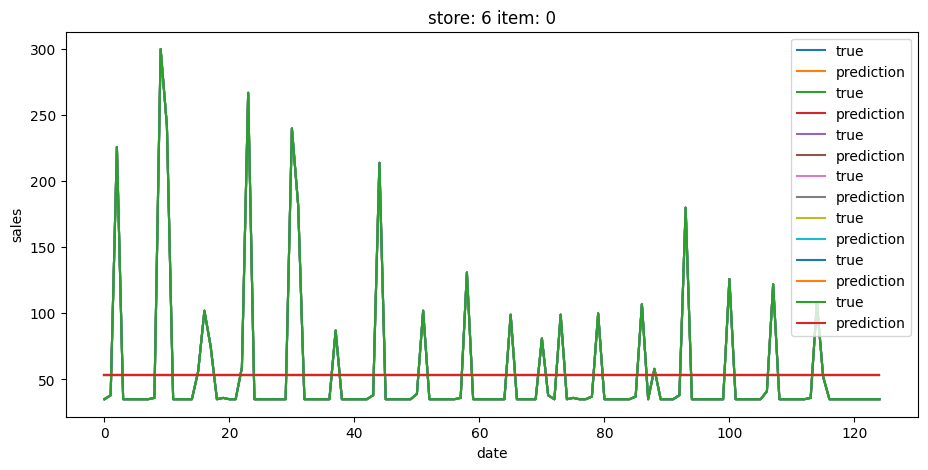

In [15]:
plt.figure(figsize=(11, 5))
plot_predictions(reverse_test, pred_test_all, 6, 0)

In [16]:
y_true = np.sum(reverse_test, axis=1)
pred = np.sum(pred_test_all, axis=1)


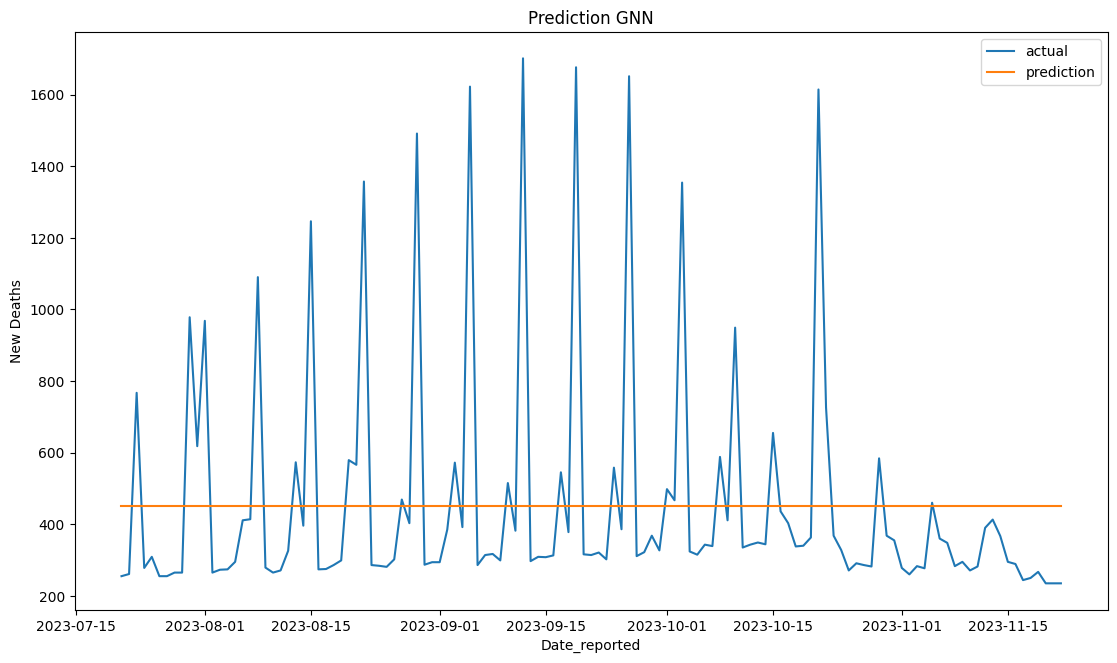

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(unique_dates[-len(pred):], y_true-1, label="actual")
ax.plot(unique_dates[-len(pred):], pred-1, label="prediction")
ax.set_title("Prediction GNN")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [20]:
print_evaluation_metrics(pred-1, y_true-1, np.sum(y_train, axis=1)-1)

Evaluation Metrics:
MSE: 113212.52
RMSE: 336.47
MAE: 216.02
MAPE: 45.36
SMAPE: 41.34
MASE: 0.12
